# Import required libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import nibabel as nib
import nrrd
import numpy as np
import os
import pandas as pd
import pickle
import scipy.ndimage as ndi
import warnings

from constants import Constants
from plot_lib.plot_lib import plot_multi_mask

from IPython.display import Image
from pathlib import Path

warnings.filterwarnings('ignore')

constants = Constants()

# Gather all available data

In [2]:
PROCESSED = constants.processed

PLOTTING = constants.plotting
LABELS = constants.labels_pkl
MASKS = constants.masks

In [3]:
def get_patient_data(patient_id, labels):
    patient_data = {}
    for c, prox_id in enumerate(labels.ProxID):
        if prox_id == patient_id:
            patient_data['ProxID'] = labels.ProxID.iloc[c]
            patient_data['ClinSig'] = labels.ClinSig.iloc[c]
            patient_data['fid'] = labels.fid.iloc[c]
            patient_data['pos'] = labels.pos.iloc[c]
            patient_data['zone'] = labels.zone.iloc[c]
            patient_data['spacing'] = labels.spacing.iloc[c]
            patient_data['slices'] = labels.slices.iloc[c]
            patient_data['T2'] = labels.T2.iloc[c]
            patient_data['ADC'] = labels.ADC.iloc[c]
            patient_data['DWI'] = labels.DWI.iloc[c]
            patient_data['KTrans'] = labels.KTrans.iloc[c]
    return patient_data


def get_patientID(filename):
    return filename[:14]

In [4]:
def get_patients(labels):
    patients = {}

    for patient_id in labels.ProxID:
        patient = get_patient_data(patient_id=patient_id, labels=labels)
        
        patients[patient_id] = {
            'data' : {
                'clin_sig' : patient['ClinSig'],
                'fid'      : patient['fid'],
                'pos'      : patient['pos'],
                'zone'     : patient['zone'],
                'spacing'  : patient['spacing'],
                'slices'   : patient['slices']  
            },
            'images' : {
                't2'     : patient['T2'],
                'adc'    : patient['ADC'],
                'dwi'    : patient['DWI'],
                'ktrans' : patient['KTrans']
            },
            'masks' : {          # Prostate and central zone segmentation masks
                'prostate' : os.path.join(MASKS, patient_id + '_msk.nrrd'),
                'cz'       : os.path.join(MASKS, patient_id + '_cz_msk.nrrd')
            },
            'plotting' : {
                # Generated data through https://github.com/OscarPellicer/prostate_lesion_detection/
                'img'  : os.path.join(PLOTTING, patient_id + '_img.nii.gz'),
                'rois' : os.path.join(PLOTTING, patient_id + '_rois.nii.gz')
            }
        }
        
    return patients


# Get all patients information
labels = pd.read_pickle(LABELS)
patients = get_patients(labels)

# Display an example

## Display patient information

In [5]:
# Display patients map example
patient_id_example = 'ProstateX-0000'     # TODO : change the ID

print(
    f'All data:\n{patients[patient_id_example]}\n\n'
    f'Patient {patient_id_example}:\n{patients[patient_id_example]["data"]}\n\n'
    f'Available images:\n{patients[patient_id_example]["images"]}\n\n'
    f'Prostate lesion masks:\n{patients[patient_id_example]["masks"]}\n\n'
    f'Plotting data:\n{patients[patient_id_example]["plotting"]}\n\n'
)

t2_images = []
adc_images = []
dwi_images = []

for t2 in patients[patient_id_example]['images']['t2']:
    t2_images.append(nib.load(t2).get_fdata())
for adc in patients[patient_id_example]['images']['adc']:
    adc_images.append(nib.load(adc).get_fdata())
for dwi in patients[patient_id_example]['images']['dwi']:
    dwi_images.append(nib.load(dwi).get_fdata())

ktrans_image = nib.load(patients[patient_id_example]['images']['ktrans']).get_fdata()

plotting_img = nib.load(patients[patient_id_example]['plotting']['img']).get_fdata()
plotting_rois = nib.load(patients[patient_id_example]['plotting']['rois']).get_fdata()

mask, _ = nrrd.read(patients[patient_id_example]['masks']['prostate'])
cz_mask, _ = nrrd.read(patients[patient_id_example]['masks']['cz'])

print(
    f'Data shapes:\n'
    f'T2: {t2_images[0].shape}\n'
    f'ADC: {adc_images[0].shape}\n'
    f'DWI: {dwi_images[0].shape}\n'
    f'Ktrans: {ktrans_image.shape}\n'
    f'Lesion mask: {mask.shape}\n'
    f'Central zone mask: {cz_mask.shape}\n'
    f'Plotting generated image: {plotting_img.shape}\n'
    f'Plotting generated rois: {plotting_rois.shape}\n'
)

All data:
{'data': {'clin_sig': [True], 'fid': [1], 'pos': ['25.7457 31.8707 -38.511'], 'zone': ['PZ'], 'spacing': (0.5, 0.5, 3.0), 'slices': [7, 8, 9, 10, 11, 12, 13]}, 'images': {'t2': [WindowsPath('data/processed/ProstateX-0000_t2_tse_tra_t2_tse_tra.nii.gz')], 'adc': [WindowsPath('data/processed/ProstateX-0000_ep2d_diff_tra_ep2d_diff_tra_DYNDIST_ADC.nii.gz')], 'dwi': [WindowsPath('data/processed/ProstateX-0000_ep2d_diff_tra_ep2d_diff_tra_DYNDIST_0.nii.gz'), WindowsPath('data/processed/ProstateX-0000_ep2d_diff_tra_ep2d_diff_tra_DYNDIST_1.nii.gz'), WindowsPath('data/processed/ProstateX-0000_ep2d_diff_tra_ep2d_diff_tra_DYNDIST_2.nii.gz')], 'ktrans': WindowsPath('data/processed/ProstateX-0000-Ktrans.nii.gz')}, 'masks': {'prostate': 'ProstateX_masks\\ProstateX-0000_msk.nrrd', 'cz': 'ProstateX_masks\\ProstateX-0000_cz_msk.nrrd'}, 'plotting': {'img': 'ProstateX_plotting\\ProstateX-0000_img.nii.gz', 'rois': 'ProstateX_plotting\\ProstateX-0000_rois.nii.gz'}}

Patient ProstateX-0000:
{'clin_s

## Plot the information

### Visualize sequences types

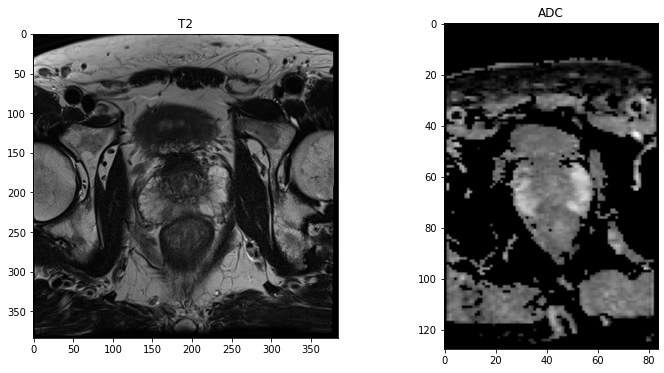

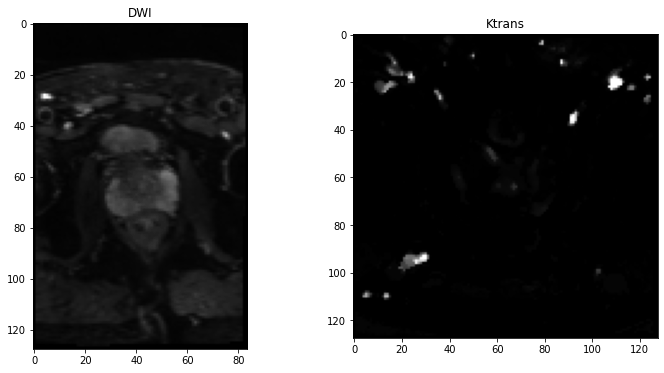

In [6]:
t2_image = t2_images[0]
adc_image = adc_images[0]
dwi_image = dwi_images[0]

fig1, (ax0, ax1) = plt.subplots(1, 2, figsize = (12, 6))
fig2, (ax2, ax3) = plt.subplots(1, 2, figsize = (12, 6))

ax0.imshow(ndi.rotate(t2_image[:, :, t2_image.shape[2]//2], 90), cmap='gray')
ax0.set_title('T2');

ax1.imshow(ndi.rotate(adc_image[:, :, adc_image.shape[2]//2], 90), cmap='gray')
ax1.set_title('ADC');

ax2.imshow(ndi.rotate(dwi_image[:, :, dwi_image.shape[2]//2], 90), cmap='gray')
ax2.set_title('DWI');

ax3.imshow(ndi.rotate(ktrans_image[:, :, ktrans_image.shape[2]//2], 90), cmap='gray')
ax3.set_title('Ktrans');

### Visualize DWI contrasts

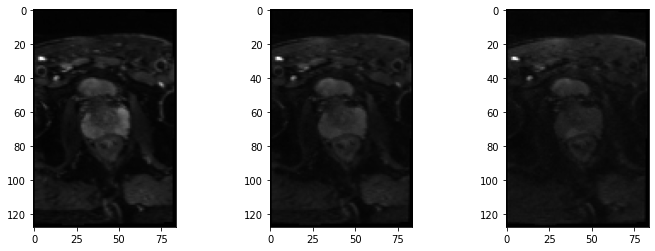

In [7]:
num_dwi = len(dwi_images)
fig, axs = plt.subplots(1, num_dwi, figsize = (12, 4))

for idx in range(num_dwi):
    dwi = dwi_images[idx]
    axs.flat[idx].imshow(ndi.rotate(dwi[:, :, dwi.shape[2]//2], 90), cmap='gray')

### Visualize masks applied on T2 sequences 

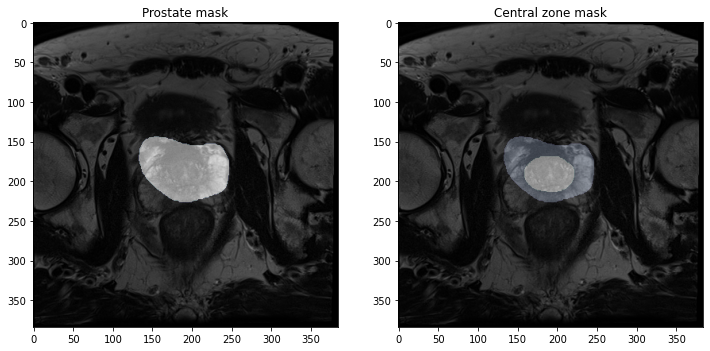

In [8]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (12, 6))
ax0.imshow(ndi.rotate(t2_image[:, :, t2_image.shape[2]//2], 90), cmap='gray')
ax0.imshow(ndi.rotate(mask[:, :, mask.shape[2]//2], 90), alpha=0.5, cmap='bone')
ax0.set_title('Prostate mask');

ax1.imshow(ndi.rotate(t2_image[:, :, t2_image.shape[2]//2], 90), cmap='gray')
ax1.imshow(ndi.rotate(cz_mask[:, :, cz_mask.shape[2]//2], 90), alpha=0.5, cmap='bone')
ax1.set_title('Central zone mask');

### Visualize lesions

In [9]:
number_of_plots = 8        # TODO : change the number of plots to be displayed
titles = [
    'T2',
    'DWI - Contrast B500',
    'DWI - Contrast B800',
    'ADC',
    'KTrans',
    'Prostate Mask',
    'Central Zone Mask',
    'Peripheral Zone Mask'
]


for c in range(number_of_plots):
    plot_multi_mask(plotting_img[:,:,:,c], plotting_rois, title=titles[c])

interactive(children=(IntSlider(value=12, description='z', max=23, style=SliderStyle(handle_color='lightblue')…

interactive(children=(IntSlider(value=12, description='z', max=23, style=SliderStyle(handle_color='lightblue')…

interactive(children=(IntSlider(value=12, description='z', max=23, style=SliderStyle(handle_color='lightblue')…

interactive(children=(IntSlider(value=12, description='z', max=23, style=SliderStyle(handle_color='lightblue')…

interactive(children=(IntSlider(value=12, description='z', max=23, style=SliderStyle(handle_color='lightblue')…

interactive(children=(IntSlider(value=12, description='z', max=23, style=SliderStyle(handle_color='lightblue')…

interactive(children=(IntSlider(value=12, description='z', max=23, style=SliderStyle(handle_color='lightblue')…

interactive(children=(IntSlider(value=12, description='z', max=23, style=SliderStyle(handle_color='lightblue')…

## Plot series 

In [10]:
def plot_nifti(example_img, masks=None, fig_rows=1, fig_cols=4):
    n_subplots = fig_rows * fig_cols
    n_slice = example_img.shape[2]
    step_size = n_slice // n_subplots
    plot_range = n_subplots * step_size
    start_stop = int((n_slice - plot_range) / 2)

    fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

    for idx, img in enumerate(range(start_stop, plot_range, step_size)):
        axs.flat[idx].imshow(ndi.rotate(example_img[:, :, img], 90), cmap='gray')
        
        if masks:
            cz_mask, _ = nrrd.read(masks['cz'])
            axs.flat[idx].imshow(ndi.rotate(cz_mask[:, :, img], 90), alpha=0.5, cmap='bone')
        
    plt.tight_layout()
    plt.show()

### T2-weighted, ADC, DWI, and KTrans series


T2 series:


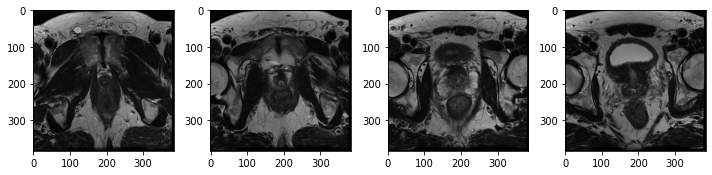


ADC series:


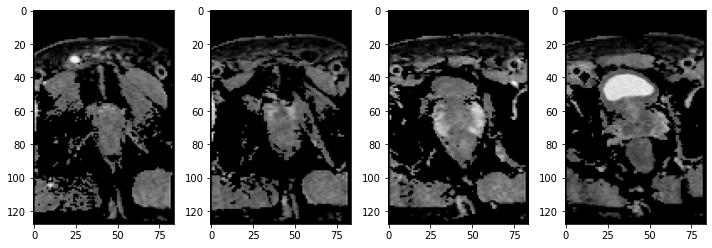


DWI series:


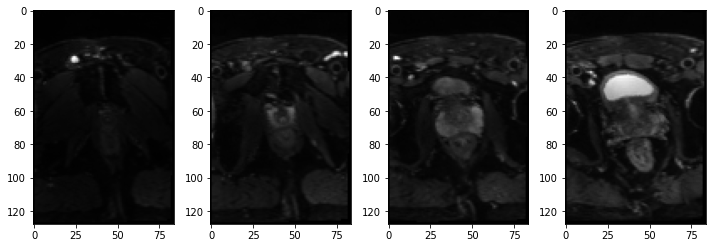


KTrans series:


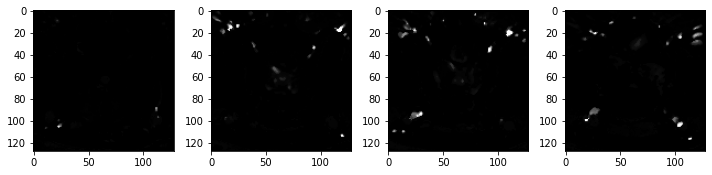


T2 series - peripheral mask:


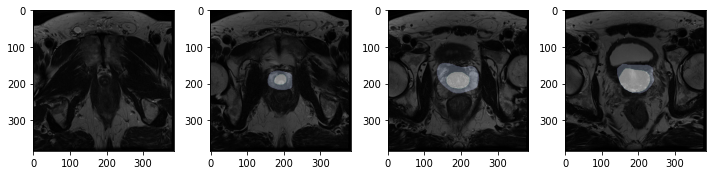

In [11]:
print(f'\nT2 series:')
plot_nifti(t2_image)

print(f'\nADC series:')
plot_nifti(adc_image)

print(f'\nDWI series:')
plot_nifti(dwi_image)

print(f'\nKTrans series:')
plot_nifti(ktrans_image)

print(f'\nT2 series - peripheral mask:')
plot_nifti(
    t2_image, 
    masks=patients[patient_id_example]['masks']
)

### Coronal and sagittal T2 series 

In [12]:
COR = Path('data/unprocessed/NIFTI/ProstateX-0000_t2_tse_cor_t2_tse_cor.nii.gz')
SAG = Path('data/unprocessed/NIFTI/ProstateX-0000_t2_tse_sag_t2_tse_sag.nii.gz')


Coronal T2 series:


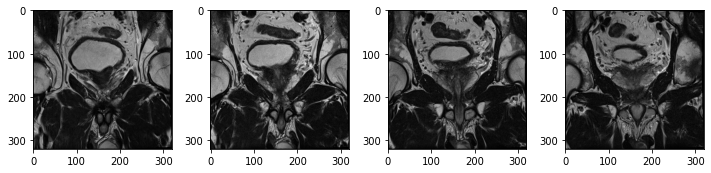


Sagittal T2 series:


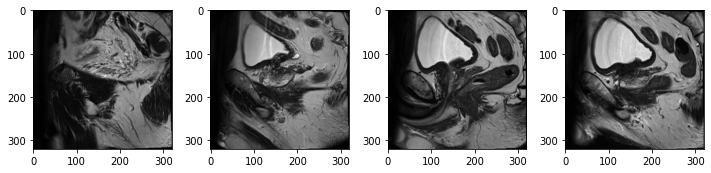

In [13]:
t2_cor = nib.load(COR).get_fdata()
t2_sag = nib.load(SAG).get_fdata()

print(f'\nCoronal T2 series:')
plot_nifti(t2_cor)

print(f'\nSagittal T2 series:')
plot_nifti(t2_sag)